<a href="https://colab.research.google.com/github/vasiliyeskin/MachineLearningExperiences/blob/master/transfer_learning/cats_and_dogs_vgg16_transfer_additionData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Подготовка данных для распознавания котов и собак на изображениях**
Источник данных - соревнования Kaggle Dogs vs. Cats.

Пример подготовки данных для обучения нейронной сети на Keras. Данные разбиваются на три каталога:

train (данные для обучения)
val (данные для проверки)
test (данные для тестирования)
В каждом каталоге создаются по два подкаталога, в соответсвии с названиями классов: cats и dogs.

Изображения переписваются из исходного каталога в новую структуру. По-умолчанию для обучения используется 70% изображений, для проверки - 15%, для тестрования также 15%.

Перед запуском необходимо скачать файл train.zip с набором изображений кошек и собак с сайта соревнования Kaggle Dogs vs. Cats и распаковать его.

In [1]:
import shutil
import os


In [ ]:
!pip install tensorflow-datasets

In [2]:
import tensorflow_datasets as tfds

In [3]:
# ds = tfds.load('cats_vs_dogs', split='train',data_dir='/content/traindata')

import tensorflow as tf
import tensorflow_datasets as tfds
from uuid import uuid1
import os
import warnings

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    with_info=True,
    data_dir=r'/content/traindata')

def save_dataset_as_jpegs(dataset, path,):
    """

    saves every image to the 'path' using random name + target

    :param dataset: dataset you want to save
    :param path: where you want to store it
    :param metadata: metadata from dataset. required to get class names.
    :return: Nothing. Just saves the dataset as jpegs.
    """

    for obj in dataset:
        im, name = obj['image'], obj['image/filename']
        serialized_im = tf.image.encode_jpeg(im)

        path_and_name = os.path.join(path, name.numpy().decode())
        tf.io.write_file(path_and_name, serialized_im)

save_dataset_as_jpegs(raw_train, '/content/traindata/jpegs_train/')
save_dataset_as_jpegs(raw_validation, '/content/traindata/jpegs_val/')
save_dataset_as_jpegs(raw_test, '/content/traindata/jpegs_test/')


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /content/traindata/cats_vs_dogs/4.0.0.incompleteTB6HS4/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /content/traindata/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# Каталог с набором данных
data_dir = '/content/traindata/jpegs_train/PetImages'
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Часть набора данных для тестирования
test_data_portion = 0.15
# Часть набора данных для проверки
val_data_portion = 0.15
# Количество элементов данных в одном классе
# nb_images = 12500
nb_images = 11224

Функция создания каталога с двумя подкаталогами по названию классов: cats и dogs

In [ ]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, "cats"))
    os.makedirs(os.path.join(dir_name, "dogs"))


Создание структуры каталогов для обучающего, проверочного и тестового набора данных

In [ ]:
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

Функция копирования изображений в заданный каталог. Изображения котов и собак копируются в отдельные подкаталоги

In [ ]:
def copy_images(start_index, end_index, source_dir, dest_dir):
    for i in range(start_index, end_index):
      try:
        shutil.copy2(os.path.join(source_dir + '/Cat', str(i) + ".jpg"), 
                    os.path.join(dest_dir, "cats"))
        shutil.copy2(os.path.join(source_dir + '/Dog', str(i) + ".jpg"), 
                   os.path.join(dest_dir, "dogs"))
      except:
          continue
        

Расчет индексов наборов данных для обучения, приверки и тестирования

In [ ]:
start_val_data_idx = int(nb_images * (1 - val_data_portion - test_data_portion))
start_test_data_idx = int(nb_images * (1 - test_data_portion))
print(start_val_data_idx)
print(start_test_data_idx)

7856
9540



Копирование изображений

In [ ]:
copy_images(100, start_val_data_idx, data_dir, train_dir)
copy_images(start_val_data_idx, start_test_data_idx, data_dir, val_dir)
copy_images(start_test_data_idx, nb_images, data_dir, test_dir)

In [ ]:
# !cd /content/traindata/jpegs_train/PetImages/Cat

In [ ]:
# !ls

# Распознавание собак и кошек на изображениях с помощью предварительно обученной нейронной сети VGG16

Источник данных - соревнования Kaggle Dogs vs. Cats.

Для распознавания используется предварительно обученная сверточная нейронная сеть VGG16.

Перед использованием необходимо скачать и подготовить данные для обучения, проверки и тестирования. Можно использовать пример в ноутбуке data_preparation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [6]:
!find /content/traindata/jpegs_train/PetImages/Cat/ -type f -print | wc -l
!find /content/traindata/jpegs_val/PetImages/Cat/ -type f -print | wc -l
!find /content/traindata/jpegs_test/PetImages/Cat/ -type f -print | wc -l
!find /content/traindata/jpegs_train/PetImages/Dog/ -type f -print | wc -l
!find /content/traindata/jpegs_val/PetImages/Dog/ -type f -print | wc -l
!find /content/traindata/jpegs_test/PetImages/Dog/ -type f -print | wc -l

8195
1743
1720
8088
1747
1769


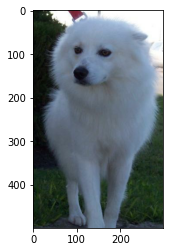

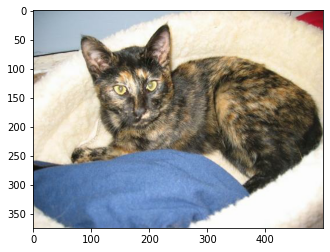

In [7]:
# !ls /content/traindata/jpegs_train/PetImages/Dog/
# отрисовка изображений
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/traindata/jpegs_train/PetImages/Dog/31.jpg')
imgplot = plt.imshow(img)
plt.show()
img = mpimg.imread('/content/traindata/jpegs_train/PetImages/Cat/31.jpg')
imgplot = plt.imshow(img)
plt.show()

In [19]:
# # Каталог с данными для обучения
# train_dir = 'train'
# # Каталог с данными для проверки
# val_dir = 'val'
# # Каталог с данными для тестирования
# test_dir = 'test'
# Каталог с данными для обучения
train_dir = '/content/traindata/jpegs_train/PetImages'
# Каталог с данными для проверки
val_dir = '/content/traindata/jpegs_val/PetImages'
# Каталог с данными для тестирования
test_dir = '/content/traindata/jpegs_test/PetImages'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Размер мини-выборки
batch_size = 64
# Количество изображений для обучения
# nb_train_samples = 17500
nb_train_samples = 16283
# Количество изображений для проверки
# nb_validation_samples = 3750
nb_validation_samples = 3490
# Количество изображений для тестирования
# nb_test_samples = 3750
nb_test_samples = 3489 


**Загружаем предварительно обученную нейронную сеть**

In [20]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

"Замораживаем" веса предварительно обученной нейронной сети VGG16

In [10]:
vgg16_net.trainable = False

In [ ]:
vgg16_net.summary()

**Создаем составную нейронную сеть на основе VGG16**

In [12]:
model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.summary()


Компилируем составную нейронную сеть

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

**Создаем генератор изображений**
Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселов изображения на 255.

In [14]:
datagen = ImageDataGenerator(rescale=1. / 255)

Генератор данных для обучения на основе изображений из каталога

In [15]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 16283 images belonging to 2 classes.


Генератор данных для проверки на основе изображений из каталога

In [16]:
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 3490 images belonging to 2 classes.


Генератор данных для тестирования на основе изображений из каталога

In [17]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 3489 images belonging to 2 classes.



# **Обучаем модель с использованием генераторов**
train_generator - генератор данных для обучения

validation_data - генератор данных для проверки

In [18]:
# model.fit_generator(
#     train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
#     epochs=10,
#     validation_data=val_generator,
#     validation_steps=nb_validation_samples // batch_size)
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)


Epoch 1/10
254/254 [==============================] - 96s 379ms/step - loss: 0.4182 - accuracy: 0.8074 - val_loss: 0.2731 - val_accuracy: 0.8970
Epoch 2/10
254/254 [==============================] - 94s 370ms/step - loss: 0.2663 - accuracy: 0.8903 - val_loss: 0.2251 - val_accuracy: 0.9120
Epoch 3/10
254/254 [==============================] - 94s 370ms/step - loss: 0.2246 - accuracy: 0.9100 - val_loss: 0.2017 - val_accuracy: 0.9210
Epoch 4/10
254/254 [==============================] - 94s 370ms/step - loss: 0.2021 - accuracy: 0.9214 - val_loss: 0.1866 - val_accuracy: 0.9262
Epoch 5/10
254/254 [==============================] - 94s 369ms/step - loss: 0.1827 - accuracy: 0.9289 - val_loss: 0.1773 - val_accuracy: 0.9291
Epoch 6/10
254/254 [==============================] - 94s 369ms/step - loss: 0.1704 - accuracy: 0.9333 - val_loss: 0.1744 - val_accuracy: 0.9320
Epoch 7/10
254/254 [==============================] - 93s 365ms/step - loss: 0.1583 - accuracy: 0.9406 - val_loss: 0.1666 - val_ac

KeyboardInterrupt: ignored

# **Оцениваем качество работы сети с помощью генератора**

In [ ]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.


In [ ]:
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 90.57%


# **Тонкая настройка сети (fine tuning)**

"Размораживаем" последний сверточный блок сети VGG16

In [ ]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [ ]:
# Проверяем количество обучаемых параметров
model.summary()

In [ ]:

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=2,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/2
254/254 [==============================] - 75s 295ms/step - loss: 0.1833 - accuracy: 0.9246 - val_loss: 0.1636 - val_accuracy: 0.9334
Epoch 2/2
254/254 [==============================] - 75s 294ms/step - loss: 0.1229 - accuracy: 0.9523 - val_loss: 0.1591 - val_accuracy: 0.9358


In [ ]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 93.34%
